In [1]:
import numpy as np
import pandas as pd
import torch
import os
import time 
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(font_scale=1)

import importlib
import random 
from skbio import TreeNode
from SimulationResult import SimulationResult
from scipy.spatial.distance import pdist, squareform

In [2]:
## How many cells does the real data end up with?
## Did this seed from one cell? 

import pickle
with open('d21_indel_distributions.p', 'rb') as f:
    indel_distributions = pickle.load(f)

slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
plot_distributions = False
for li in [slow_guides, medium_guides, fast_guides]:
    for guide in li:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        
        if plot_distributions:
            distvals = np.array(sorted(list(dist.values()), reverse=True))
            distvals = distvals/distvals.sum()
            plt.figure()
            sns.barplot(np.arange(len(distvals)), distvals, linewidth=0)
            plt.title('Density over different edits for guide {0}'.format(guide))
            plt.show()
            plt.close()

# Estimate the mutation probability

# For a given site E_i[%] = E_{i-1}[%] + p(1-E_{i-1}[%])
# E_i = 1-q^i, where q = 1-p 
# Sanity check: 
# E_0 = 1-(1-p)^0 = 0 
# E_1 = 1-(1-p) = p 

# We can choose to use a combination of varying speed guides 

# 4, 7, 14, 21 days -> 4 generations, 7 generations etc (24 hrs for cell cycle?)

# How many generations does 1 day correspond to?
# Slow guides:
slow = [0.09, 0.15, 0.29, 0.4]

# Medium guides
medium = [0.15, 0.35, 0.6, 0.75]

# Fast guides
fast = [0.75, 0.9, 0.95, 0.96]





Slow
0.02330188829047808
0.02294954933760507
0.02416678505263603
0.024031560532588148
Avg
0.02361244580332683

Medium
0.03981541059581217
0.05968505934696777
0.06335350204906998
0.0638822575463951
Avg
0.056684057384561254

Fast
0.2928932188134524
0.28031432699884795
0.19263617565013524
0.14211035031316765
Avg
0.22698851794390082


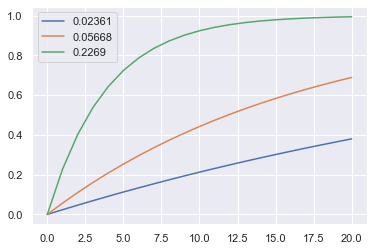

In [3]:
gens = [4,7,14,21]
print('\nSlow')
p_avg = 0
for i, x in enumerate(slow):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nMedium')
p_avg = 0
for i, x in enumerate(medium):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)

print('\nFast')
p_avg = 0
for i, x in enumerate(fast):
    G = 1/gens[i]
    p = 1 - (1-x)**G
    p_avg += p
    print(p)
print("Avg")
print(p_avg/4)    

""" 
Questions
1. tree or forest
2. are the rates based on isolating a clone or from a forest
3. yosef lab was a single tree?? no

try this instead: 
start with many roots (a forest)

reproduction rate varying / same ?vfr 

"""

plt.figure()
for p in [0.02361, 0.05668, 0.2269]:
    q = 1-p
    plt.plot(np.arange(21), 1-q**np.arange(21), label=p)
plt.legend()
plt.show()
plt.close()

rate = {}
rate['slow'] = 0.02361
rate['medium'] = 0.05668
rate['fast'] = 0.2269

## Perform a lineage tracing experiment 

In [4]:
slow_guides = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'TATTGCCTCTTAATCGTCTT']
medium_guides = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TTAAGTTTGAGCTCGCGCAA']
fast_guides = ['TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']

ssm = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT','AATCCCTAGTAGATTAGCCT']
smm = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA']
ssf = ['AGCTGCTTAGGGCGCAGCCT', 'CTCCTTGCGTTGACCCGCTT', 'CCTCCCGTAGTGTTGAGTCA']
smf = ['AGCTGCTTAGGGCGCAGCCT', 'AATCCCTAGTAGATTAGCCT', 'CCTCCCGTAGTGTTGAGTCA']
sff = ['AGCTGCTTAGGGCGCAGCCT', 'CTTCCACGGCTCTAGTACAT', 'CCTCCCGTAGTGTTGAGTCA']
mmf = ['AATCCCTAGTAGATTAGCCT', 'CACAGAACTTTATGACGATA', 'TAATTCCGGACGAAATCTTG']
mff = ['AATCCCTAGTAGATTAGCCT', 'TAATTCCGGACGAAATCTTG', 'CTTCCACGGCTCTAGTACAT']


results = {'Guides':[], 'Num_Distinct_Edits':[], 
           'Min_depths':[], 'Num_Mutations':[],
           'Recurring_Characters':[],  
           'Recurring_Characters_%':[],
           'Recurring_Mutations' : [],
           'Recurring_Mutations_%': []
          }

subsampled_results = {'Guides':[], 'Total_Mutations':[], 'Distinct_Mutations':[], 'Recurring_Mutations':[], 'Recurring_Mutations_%':[], 'Unique_Cells': [] }

timers = {}

lists_of_guides = [slow_guides, ssm, smm, ssf, smf, sff, medium_guides, mmf, mff, fast_guides]
labels = ['sss','ssm','smm','ssf','smf','sff', 'mmm', 'mmf','mff', 'fff']
verbose = False
tree_depth = 20
num_runs = 3
n_subsample = 1000
num_arrays = 10

init_cell_list = [1, 5, 10, 50, 100]

debug = True
compute_tree = False

if debug:
    lists_of_guides = [fast_guides]
    labels = ['smf']
    tree_depth = 20
    num_runs = 1
    n_subsample = 20
    num_arrays = 10
    init_cell_list = [1]


Label: smf
List of targets:  [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2), (7, 0), (7, 1), (7, 2), (8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2)]
level ['0']
level ['01']
level ['010']
level ['0100']
level ['01000', '01000']
level ['010000', '010001', '010001']
level ['0100001', '0100001', '0100010', '0100011']
level ['01000010', '01000010', '01000011', '01000011', '01000101', '01000101', '01000110']
level ['010000100', '010000101', '010000110', '010000111', '010001010', '010001011', '010001011', '010001100']
level ['0100001001', '0100001010', '0100001010', '0100001101', '0100001101', '0100001110', '0100001110', '0100010100', '0100010110', '0100010111', '0100011001']
level ['01000010011', '01000010100', '01000010100', '01000010101', '01000011010', '01000011011', '01000011100', '01000011100', '01000011101', '01000101000', '01000101000', '01000101100', '01000101111'

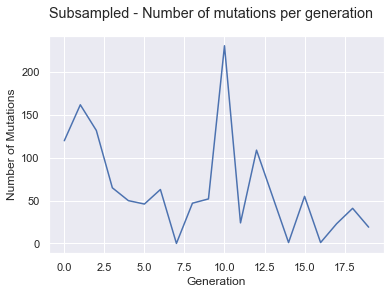

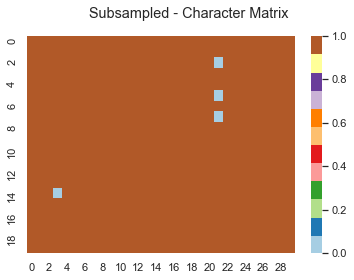

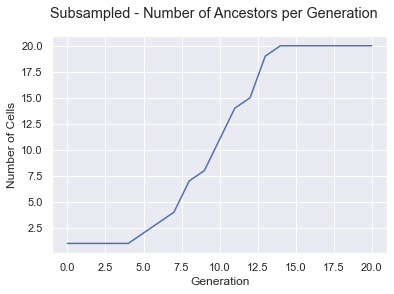

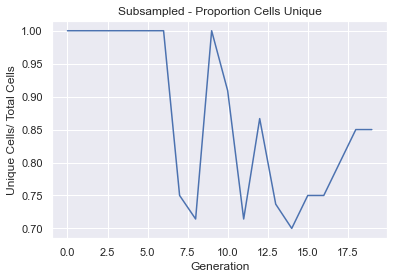

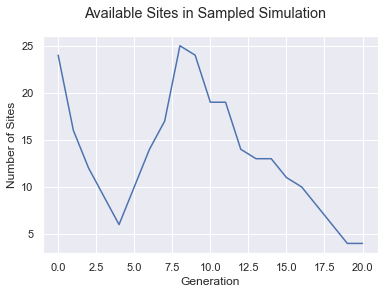

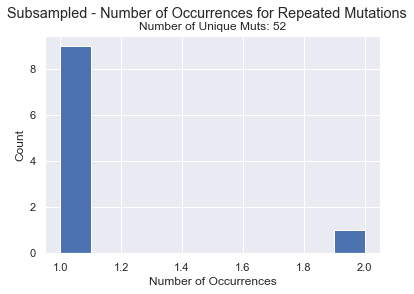

In [5]:
from crispr_lib import lineageSimulationImbalanced 

simulation_list = []

for i, list_of_guides in enumerate(lists_of_guides):
    label = labels[i]
    print('Label:', label)

    # Each array has 3-6 targets, we insert ~10 arrays. This gives us 30-60 sites
    site_ix = 0
    target_distributions = {}
    speed = {}
    for guide in list_of_guides:
        dist = indel_distributions[guide]
        try:
            del dist['']
        except KeyError:
            pass
        distvals = np.array(sorted(list(dist.values()), reverse=True))
        distvals = distvals/distvals.sum()
        target_distributions[site_ix] = distvals
        if guide in slow_guides:
            speed[site_ix] = 'slow'
        elif guide in medium_guides:
            speed[site_ix] = 'medium'
        else:
            speed[site_ix] = 'fast'

        site_ix += 1

    num_targets = site_ix 
    num_edit_sites = num_targets * num_arrays

    import itertools
    targets = list(itertools.product(np.arange(num_arrays), np.arange(num_targets)))
    print('List of targets: ', targets)

    deletions = []
    mutation_probs = []
    for array, target in targets:
        deletions.append(target_distributions[target])
        mutation_probs.append(rate[speed[target]])
        
    deletions_probs = pd.DataFrame(deletions)
    deletions_probs = torch.DoubleTensor(deletions_probs.fillna(0.0).values)
    
    # Each edit site has a different mutation probability 
    mutation_probs= np.array(mutation_probs)

    deletions_probs = deletions_probs[:, :100]
    deletions_probs /= deletions_probs.sum(1, keepdims=True)
    
    edit_probs = np.hstack([mutation_probs.reshape(-1,1), (1-mutation_probs.reshape(-1,1))*deletions_probs.numpy()])
    
    
    
    for init_cells in init_cell_list:

        for run in range(num_runs):
            
            try:
                simulation = lineageSimulationImbalanced(label, tree_depth, 
                                               num_edit_sites, deletions_probs, 
                                               mutation_probs, edit_probs, 
                                                         init_cells=init_cells, 
                                                         n_subsample=n_subsample,
                                                         identify_recurrent_muts=False)
                
                simulation_list.append(simulation)
            except Exception as e:
#                 print(e)
                raise(e)

## Tree Reconstructions 

Compare various methods of tree reconstruction to determine which has the best performance

In [98]:
from skbio import TreeNode
class CellGroupNode(TreeNode):
    """
    An abstract class for all nodes in a tree. 

    Attributes:
    - feature_matrix: dataframe consisting of the feature matrix of all cells contained in this node 
    
    Methods:
    - get_character_string: utility function for getting character string
    - get_name: utility for getting the name of the node
    - get_character_vec: utility for getting the character vector
    - get_edit_distance: calculate the edit distance between two nodes
    - get_modified_hamming_dist: calculate hamming distance between nodes, taking into account mutagenesis process
    - get_mut_length: get a 0 - 1 value indicating the proportion of non-missing characters are different between two nodes

    """
    # Inherit init method from skbio
    def add_character_matrix(self, char_vec):
        """
        A dataframe of character states, of length C for cells in this group. All Nodes in a tree should have the same number of characters.
        """
        self.char_matrix = char_vec 
    
    def get_character_matrix(self):
        return self.char_matrix
        
    def add_feature_matrix(self, feature_matrix):
        """
        A dataframe containing a binarized version of the character states for cells in this group. 
        The length of this depends on the number of unique character/site combinations
        """
        self.feature_matrix = feature_matrix
    
    def get_feature_matrix(self):
        return self.feature_matrix 
    
    def add_defining_muts(self, muts):
        self.muts = muts
        
    def get_all_defining_mutations(self):
        """
        Combine all the mutations which defined this lineage
        """
        return None 
    
def mod_nj(feature_matrix, character_matrix, prob_features, result_constructor=None):
    fm = copy.deepcopy(feature_matrix)
    
    fm = fm.values 
    
    Qs = []
    Ds = []
    Rs = [] 
    joins = []
    
    names = feature_matrix.index 
       
    
    log_prob_features = np.log(prob_features)
    log_prob_features[-log_prob_features == np.inf] = -10000 #hacky
    
    
    # Compute the distance matrix
    D = squareform(pdist(fm, lambda u,v: (- (u + v - 2*u*v) * log_prob_features).sum()))
    
    tree_nodes = {}
    
    for name in names:
        node = CellGroupNode(name=str(name))
        # Associate feature matrix and character matrix to leaf nodes 
        node.add_feature_matrix(feature_matrix.loc[name])
        node.add_character_matrix(character_matrix.loc[name])
        tree_nodes[name] = node 
        
    print('Starting with {0} nodes'.format(len(D)))
    new_name = len(D)
    
    new_lcas = {}
    while len(D) > 2:
              
        s = time.time()
        # Compute the Q matrix -> Q(ij)=d(ij) - [r(i) + r(j)]/(N-2)
        R  = np.tile(D.sum(0), (fm.shape[0], 1))
        
        R = (R + R.T)
        
        Q = D*(fm.shape[0]-2) - R
        
        Q = D 
        
        Qs.append(Q)
        Ds.append(D)
        Rs.append(R)
        
        
        # Convert Q martix to lower triangular form without the diagonal to avoid merging the same site
        Q[np.tril_indices(Q.shape[0], 0)]  = np.inf
        
        # Now find the argmin (i,j) of Q. These are the sites the be merged
        min_i, min_j = np.unravel_index(np.argmin(Q, axis=None), Q.shape)
        s = time.time() 
        
        joins.append((names[min_i], names[min_j]))

        
        # Create a new TreeNode from the merged children
        
        new_name += 1
        
        
        child_i = tree_nodes[names[min_i]]
        child_j = tree_nodes[names[min_j]]
        new_node = CellGroupNode(name=f'nj-node={new_name}',
                                 length=None, parent=None, 
                                 children=[child_i, child_j])
        
            
        child_i.parent = new_node
        child_j.parent = new_node
        
        tree_nodes[new_name] = new_node
        
        
        names = np.delete(names, [min_i,min_j], axis=0)
        names = np.hstack([names, new_name])
        
        # Now we merge i,j. We need to replace i,j in the feature matrix with lca(i,j).
#         lca = lcas[min_i,min_j]
        lca = fm[min_i]*fm[min_j]
        fm  = np.delete(fm, [min_i,min_j], axis=0)
        fm  = np.vstack([fm, lca])
        
        new_lcas[new_name] = lca

        # We also need to replace the distance of each site k to i or j with the distance to lca(i,j)

        D = np.delete(np.delete(D, [min_i,min_j], axis=0), [min_i,min_j], axis=1)

        new_D = np.zeros((fm.shape[0], fm.shape[0]))
        new_D[:-1, :-1] = D

        new_D_row = - ((fm + fm[-1] - 2* fm * fm[-1])*log_prob_features).sum(1)


        new_D[-1, :] = new_D_row
        new_D[:, -1] = new_D_row
        D = new_D
        
        
    new_name += 1
    
    # Merge the last two remaining sites to complete the tree
    child1, child2 = tree_nodes[names[0]], tree_nodes[names[1]]
    root = CellGroupNode(name = f'nj-node={new_name}', children=[child1, child2])
    child1.parent = root
    child2.parent = root
    
    return root, {'Qs':Qs, 'Ds':Ds, 'Rs':Rs, 'joins':joins, 'lcas':new_lcas}


def greedy_probabilistic(simulation,
                        impute_missing_data=False,
                        max_cells_per_greedy_node = 2):
    
    from utilities import binarize_character_matrix 
#     from modified_nj import mod_nj
    character_matrix = simulation.get_final_cells()
    
    if impute_missing_data:
        from sklearn.impute import KNNImputer
        imputer = KNNImputer(n_neighbors=3)
        imputed = imputer.fit_transform(character_matrix)
        character_matrix= pd.DataFrame(imputed, columns=character_matrix.columns)
    
    # Convert character matrix to binary feature matrix for neighbour joining 
    feature_matrix = binarize_character_matrix(character_matrix)
    
    # Split by most frequently occuring character until cell groups are small enough to do neighbour joining efficiently. 
    def recursive_split(fm, cm):
        
        if fm.shape[0] <= max_cells_per_greedy_node:
            # Create a node containing all the cells in this subtree
            leaf = CellGroupNode('leaf-node') 
            leaf.add_feature_matrix(fm)
            leaf.add_character_matrix(cm)
            return leaf
        
        # Determine the mutation which appears in the largest number of cells (but not all the cells) 
        proportion = fm.sum(axis=0)/fm.shape[0]
        proportion[proportion==1] = 0
        
        split_on = fm.columns[np.argmax(proportion)]
        
        left_child = fm[fm[split_on]==1]
        right_child = fm[fm[split_on]!=1]
        
        left_cm = cm.loc[left_child.index]
        right_cm = cm.loc[right_child.index]

        node = CellGroupNode('g-node')

        left_child = recursive_split(left_child, left_cm)        
        left_child.add_defining_muts((split_on, 1))
        
        right_child = recursive_split(right_child, right_cm)
        right_child.add_defining_muts((split_on, 0))
        left_child.parent = node
        right_child.parent = node 

        node.children = [left_child, right_child]
        return node  
    
    greedy_tree = recursive_split(feature_matrix, character_matrix)

    # Perform probabilistic re-assignment of leaves 
    # For each leaf node, determine the profile of mutations that characterize the tip.

    # Option 1: TODO: Use all the defining mutations accumulated along this lineage
    # Option 2: Use the consensus over all cells 

    leaves = [x for x in greedy_tree.tips()]

    muts_in_leaf = []
    for i, leaf in enumerate(leaves):
        # Determine consensus of leaf, aka which mutations are present in all cells in the group.
        consensus_muts = (leaf.feature_matrix.sum(0)/leaf.feature_matrix.shape[0]) == 1
        consensus_muts = consensus_muts.astype(int).values
        muts_in_leaf.append(consensus_muts)

    # Compute triplets correct before reassignment
    star_tree = greedy_tree.copy()
    for leaf in star_tree.tips():
        # Create a star tree for the unresolved cells at the tips
        for name in leaf.char_matrix.index:
            node = CellGroupNode(str(name), parent=leaf)
            node.add_character_matrix(leaf.char_matrix.loc[name])        
            node.add_feature_matrix(leaf.feature_matrix.loc[name])

            leaf.children.append(node)

    print('todo')

    # Compute the probabilistic assignment of cells to cellgroup leaves
    fm = []
    cm = []
    original_leaf = []

    for i, leaf in enumerate(leaves):
        fm.append(leaf.feature_matrix)
        cm.append(leaf.get_character_matrix())
        original_leaf += [i]*len(fm[-1])
    fm = pd.concat(fm, axis=0)
    cm = pd.concat(cm, axis=0)

    dels_probs = simulation.get_edit_probs()
    prob_features = dels_probs[fm.columns].values
    
    original_leaf = np.array(original_leaf)

    leaf_agreement = np.dot(fm.values, np.vstack(muts_in_leaf).T)
    new_assignments = leaf_agreement.argmax(1)
    changed_assignments = (new_assignments != original_leaf).sum()
    print(f'Reassigned {changed_assignments} leaves out of a total of {len(new_assignments)} leaves.')


    fm['Updated_CellGroup'] = new_assignments
    cm['Updated_CellGroup'] = new_assignments
    
    
    # Reallocate the leaf indices of all cells into the original tree structure.
    for i, leaf in enumerate(leaves):
        leaf.add_feature_matrix(fm[fm["Updated_CellGroup"] == i].drop('Updated_CellGroup', axis=1))
        leaf.add_character_matrix(cm[cm["Updated_CellGroup"] == i].drop('Updated_CellGroup', axis=1))
        
    # If any leaf no longer has any cells, remove from the tree. 
    n_removed = 0
    for i, leaf in enumerate(leaves):
        if len(leaf.feature_matrix) == 0:
            n_removed += 1
            leaf.parent.children.remove(leaf)
    print(f'Removed {n_removed} leaves after reassigning cells.')

    # Compute the triplets correct after reassigning cells
    star_tree = greedy_tree.copy()
    for leaf in star_tree.tips():
        # Create a star tree for the unresolved cells at the tips
        for name in leaf.char_matrix.index:
            node = CellGroupNode(str(name), parent=leaf)
            node.add_character_matrix(leaf.char_matrix.loc[name])        
            node.add_feature_matrix(leaf.feature_matrix.loc[name])

            leaf.children.append(node)

    print('todo')
    
    # Finally, perform neighbor joining in each leaf to complete the tree.
    leaves = [x for x in greedy_tree.tips()]

    for leaf in leaves:
        fm = leaf.feature_matrix 
        if len(fm) < 2:
            continue 
        print('Performing neighbor joining on CellGroup')    
        root, steps = mod_nj(fm, leaf.get_character_matrix(), prob_features)
        
        root.parent = leaf.parent  
        # Replace leaf with new root 
        leaf.parent.children.remove(leaf)
        leaf.parent.children.append(root)
        
    return greedy_tree   



In [111]:

greedy_tree = greedy_probabilistic(simulation)

greedy_tree

todo


<CellGroupNode, name: g-node, internal node count: 9, tips count: 11>

In [112]:
print(greedy_tree.ascii_art())

                              /-leaf-node
                    /g-node--|
                   |         |          /-leaf-node
                   |          \g-node--|
          /g-node--|                    \-leaf-node
         |         |
         |         |          /-leaf-node
         |          \g-node--|
         |                   |          /-leaf-node
         |                    \g-node--|
-g-node--|                              \-leaf-node
         |
         |                              /-leaf-node
         |                    /g-node--|
         |                   |         |          /-leaf-node
         |          /g-node--|          \g-node--|
         |         |         |                    \-leaf-node
          \g-node--|         |
                   |          \-leaf-node
                   |
                    \-leaf-node


(1, 30)
(1, 30)
(2, 30)
(2, 30)
(2, 30)
(1, 30)
(2, 30)
(1, 30)
(2, 30)
(1, 30)
(2, 30)


In [108]:
print(greedy_tree.ascii_art())

                              /leaf-node/-4
                    /g-node--|
                   |         |          /leaf-node/-3
                   |          \g-node--|
                   |                   |          /-1
                   |                    \leaf-node
          /g-node--|                              \-2
         |         |
         |         |                    /-0
         |         |          /leaf-node
         |         |         |          \-6
         |          \g-node--|
         |                   |                    /-8
         |                   |          /leaf-node
         |                    \g-node--|          \-10
         |                             |
-g-node--|                              \leaf-node/-7
         |
         |                                        /-13
         |                              /leaf-node
         |                             |          \-15
         |                    /g-node--|
         |            

In [ ]:
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree
from cassiopeia.TreeSolver.score_triplets import score_triplets
from cassiopeia.TreeSolver.Node import Node 
from cassiopeia.TreeSolver.lineage_solver.lineage_solver import solve_lineage_instance


### Missing Data

Compare performance over varying degrees of missing data 


In [ ]:
def format_char_vec(a):
    nan_a = np.isnan(a)
    a = a.astype(np.int).astype(str)
    a[nan_a] = '-'
    return list(a)

for simulation in simulation_list:
    simulation.random_attr['missing_data_expt'] = {'frac':[],'cass':[],'ours':[],'base_score':[]}
    for frac in [0.05, 0.1, 0.2]:
        simulation.random_attr['missing_data_expt']['frac'].append(frac)
        
        priors = None

        cell_record = simulation.get_cell_record()
        # Randomly drop mutations to introduce missingness in data 
        prop = int(cell_record[-1].size * frac)
        #Randomly choose indices of the numpy array:
        i = [random.choice(range(cell_record[-1].shape[0])) for _ in range(prop)]
        j = [random.choice(range(cell_record[-1].shape[1])) for _ in range(prop)]

        cell_record[-1][i,j] = np.NaN
        
        # Modify true network to incorporate missing data 
        import networkx as nx
        from cassiopeia.TreeSolver.Node import Node

        # Create networkx DiGraph to represent true_tree 
        tree = nx.DiGraph()
        
        # Create nodes representing the leaves
        level_ix = simulation.subsampled_ix
        record = cell_record[-1]
        tips = [Node(str(i), format_char_vec(record[i])) for i in np.arange(len(level_ix))]
        
        
        ## FIX THIS 
        
        raise NotImplementedError
        
        for j in (range(simulation.tree_depth-1, -1, -1)):
            # Map the subsampled cells from the preceding level as parents/children
            parent_ix = level_ix//2
            parent_dict = {}
            record = cell_record[j]

            parent_ix_map = dict(zip(np.unique(parent_ix), np.arange(len(np.unique(parent_ix)))))        

            for i, ix in enumerate(parent_ix):
                # Get record corresponding to parent 
                parent = parent_dict.get(ix, Node(str(ix), format_char_vec(record[parent_ix_map[ix]])))
                parent_dict[ix] = parent
                tree.add_edges_from([(parent, tips[i])])

            # These are the new base layer, and we continue to build upwards
            level_ix = pd.unique(parent_ix)
            tips = [parent_dict[ix] for ix in level_ix]
            
        true_network = tree 
        
        def cassiopeia_reconstruct(true_network):
        
            leaves = [x for x in true_network.nodes() if true_network.out_degree(x)==0]
            character_matrix = pd.DataFrame([x.char_vec for x in leaves]).replace('-', np.nan).astype(np.float64)

            names = [x.name for x in leaves]
            character_matrix.index = names 

            # Cassiopeia takes a string dataframe
            cm = character_matrix.replace(np.nan, -1)
            cm = cm.astype(int).astype(str).replace('-1','-')

            cm_uniq = cm.drop_duplicates(inplace=False)
            target_nodes = cm_uniq.values.tolist()
            target_nodes = list(map(lambda x, n: Node(n,x), target_nodes, cm_uniq.index))

            t = time.time()
            reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
                                                                  method="greedy", 
                                                                  prior_probabilities=priors)
            cass_time = time.time()-t
            cass_tree = reconstructed_network_greedy[0]
            cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)

        # # Why is the score_triplets not 1??
        base_score = score_triplets(true_network, true_network, number_of_trials = 5000, min_size_depth = 20)
        print('Baseline:', base_score)

        simulation.random_attr['missing_data_expt']['base_score'].append(base_score)
        
        t = time.time()
        reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
                                                              method="greedy", 
                                                              prior_probabilities=priors)
        cass_time = time.time()-t
        cass_tree = reconstructed_network_greedy[0]
        cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)
        print('Cassiopeia Score: ', cass_score)
        print('Cassiopeia Time: ', cass_time)

        cass = [cass_tree, cass_score, cass_time]
        simulation.random_attr['missing_data_expt']['cass'].append(cass)
        

        t = time.time()
        new_priors = torch.distributions.Categorical(torch.DoubleTensor(simulation.edit_probs))
        tree, steps = cluster_nx(character_matrix, new_priors)
        our_time = time.time()-t


        our_tree = Cassiopeia_Tree(method ='simulated', network = tree)
        our_score = score_triplets(true_network, our_tree, number_of_trials = 5000, min_size_depth = 20)
        print('Our Score:', our_score)
        print('Our Time: ', our_time)
        
        ours = [our_tree, our_score, our_time]
        simulation.random_attr['missing_data_expt']['ours'].append(ours)

In [ ]:
def cassiopeia_reconstruct(true_network):
        
    leaves = [x for x in true_network.nodes() if true_network.out_degree(x)==0]
    character_matrix = pd.DataFrame([x.char_vec for x in leaves]).replace('-', np.nan).astype(np.float64)

    names = [x.name for x in leaves]
    character_matrix.index = names 

    # Cassiopeia takes a string dataframe
    cm = character_matrix.replace(np.nan, -1)
    cm = cm.astype(int).astype(str).replace('-1','-')

    cm_uniq = cm.drop_duplicates(inplace=False)
    target_nodes = cm_uniq.values.tolist()
    target_nodes = list(map(lambda x, n: Node(n,x), target_nodes, cm_uniq.index))

    t = time.time()
    priors = None 
    reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
                                                          method="greedy", 
                                                          prior_probabilities=priors)
    cass_time = time.time()-t
    cass_tree = reconstructed_network_greedy[0]
    
    true_cass_tree = Cassiopeia_Tree(method ='simulated', network = true_network)
    greedy_cass_tree = Cassiopeia_Tree(method ='greedy', network = cass_tree)
    
    cass_score = score_triplets(true_network, cass_tree, number_of_trials = 5000, min_size_depth = 20)
    
    return greedy_cass_tree, cass_score


In [ ]:
cass_tree, cass_score = cassiopeia_reconstruct(simulation.get_sampled_network())
cass_score

In [ ]:
true_network = simulation.get_sampled_network()

leaves = [x for x in true_network.nodes() if true_network.out_degree(x)==0]
character_matrix = pd.DataFrame([x.char_vec for x in leaves]).replace('-', np.nan).astype(np.float64)

names = [x.name for x in leaves]
character_matrix.index = names 

# Cassiopeia takes a string dataframe
cm = character_matrix.replace(np.nan, -1)
cm = cm.astype(int).astype(str).replace('-1','-')

cm_uniq = cm.drop_duplicates(inplace=False)
target_nodes = cm_uniq.values.tolist()
target_nodes = list(map(lambda x, n: Node(n,x), target_nodes, cm_uniq.index))

t = time.time()
priors = None 
reconstructed_network_greedy = solve_lineage_instance(target_nodes, 
                                                      method="greedy", 
                                                      prior_probabilities=priors)
cass_time = time.time()-t
greedy_cass_tree = reconstructed_network_greedy[0]

true_cass_tree = Cassiopeia_Tree(method ='simulated', network = true_network)

cass_score = score_triplets(true_network, greedy_cass_tree, number_of_trials = 5000, min_size_depth = 20)

In [ ]:
cass_tree

In [ ]:
from cass_helper import convert_nx_to_tree

print(convert_nx_to_tree(greedy_cass_tree.network).ascii_art())

In [ ]:
def condense_tree_tree(treenode):
    def condensify_node(node):
        if len(node.children) == 0:
            return node
        if len(node.children) == 1:
            child = node.children[0]
            node.children = [condensify(grandchild) for grandchild in child.children]


print(simulation.true_tree.ascii_art())